In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 29 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,841 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 124947 files and dire

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

# LSTM을 활용한 주가 예측 모델



- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

## 필요한 모듈 import

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

## 데이터 (FinanceDataReader)

**FinanceDataReader**는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

In [4]:
!pip install finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.9 MB/s eta 0:00:00


In [5]:
import FinanceDataReader as fdr

In [6]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 `DataFrame`형식으로 받아옵니다.

기본 **오름차순 정렬**이 된 데이터임을 알 수 있습니다.

### 컬럼 설명

- `Open`:   시가
- `High`:   고가
- `Low`:    저가
- `Close`:  종가
- `Volume`: 거래량
- `Change`: 대비

In [7]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2025-03-04,53900,55000,53800,54500,18553933,0.000000
2025-03-05,55100,55400,54000,54000,16578817,-0.009174
2025-03-06,54100,54500,54000,54300,12258101,0.005556
2025-03-07,53500,54200,53400,53700,14274992,-0.011050
2025-03-10,53500,54800,53500,53700,12780338,0.000000


**미국 주식 데이터**도 가져올 수 있습니다.

In [8]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL')

In [9]:
apple.tail()

,Open,High,Low,Close,Volume,Adj Close
2025-03-03,241.789993,244.029999,236.110001,238.029999,47184000,238.029999
2025-03-04,237.710007,240.070007,234.679993,235.929993,53798100,235.929993
2025-03-05,235.419998,236.550003,229.229996,235.740005,47227600,235.740005
2025-03-06,234.440002,237.860001,233.160004,235.330002,45170400,235.330002
2025-03-07,235.110001,241.369995,234.759995,239.070007,46245700,239.070007


다음과 같이 `2017`을 같이 넘겨주면, 해당 시점 이후의 주식 데이터를 가져옵니다.

In [10]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL', '2017')

In [11]:
apple.head()

,Open,High,Low,Close,Volume,Adj Close
2017-01-03,28.950001,29.082500,28.690001,29.037500,115127600,26.862431
2017-01-04,28.962500,29.127501,28.937500,29.004999,84472400,26.832363
2017-01-05,28.980000,29.215000,28.952499,29.152500,88774400,26.968811
2017-01-06,29.195000,29.540001,29.117500,29.477501,127007600,27.269470
2017-01-09,29.487499,29.857500,29.485001,29.747499,134247600,27.519243


**시작**과 **끝** 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.

In [12]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2019-12-30')

In [13]:
ford.head()

,Open,High,Low,Close,Volume,Adj Close
1980-01-02,1.297609,1.328022,1.287471,1.287471,2044376,0.217353
1980-01-03,1.287471,1.287471,1.267196,1.287471,2816257,0.217353
1980-01-04,1.287471,1.287471,1.272265,1.277334,3038203,0.215642
1980-01-07,1.277334,1.287471,1.267196,1.267196,2251526,0.213930
1980-01-08,1.267196,1.292540,1.257059,1.292540,4069022,0.218209


In [14]:
ford.tail()

,Open,High,Low,Close,Volume,Adj Close
2019-12-20,9.50,9.54,9.44,9.48,50191200,7.356348
2019-12-23,9.50,9.57,9.40,9.44,54784400,7.325309
2019-12-24,9.44,9.49,9.43,9.47,11881600,7.348590
2019-12-26,9.47,9.49,9.43,9.45,28961300,7.333068
2019-12-27,9.45,9.46,9.35,9.36,28272800,7.263229


그 밖에 **금, 은과 같은 현물**, **달러와 같은 화폐** 데이터도 가져올 수 있습니다.

In [15]:
## 주가데이터 가져오기

In [16]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [17]:
stock = fdr.DataReader(STOCK_CODE)

In [18]:
stock.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2000-11-13,3220,3260,3100,3150,1021457,NaN
2000-11-14,3210,3320,3210,3290,635154,0.044444
2000-11-15,3449,3460,3319,3390,1114464,0.030395
2000-11-16,3400,3420,3250,3280,748446,-0.032448
2000-11-17,3180,3230,3150,3220,724553,-0.018293


In [19]:
stock.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2025-03-04,53900,55000,53800,54500,18553933,0.000000
2025-03-05,55100,55400,54000,54000,16578817,-0.009174
2025-03-06,54100,54500,54000,54300,12258101,0.005556
2025-03-07,53500,54200,53400,53700,14274992,-0.011050
2025-03-10,53500,54800,53500,53700,12780338,0.000000


In [20]:
stock.index

DatetimeIndex(['2000-11-13', '2000-11-14', '2000-11-15', '2000-11-16',
               '2000-11-17', '2000-11-20', '2000-11-21', '2000-11-22',
               '2000-11-23', '2000-11-24',
               ...
               '2025-02-24', '2025-02-25', '2025-02-26', '2025-02-27',
               '2025-02-28', '2025-03-04', '2025-03-05', '2025-03-06',
               '2025-03-07', '2025-03-10'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

위에서 보시는 바와 같이 index가 `DatetimeIndex`로 지정되어 있습니다.

`DatetimeIndex`로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, **월별, 연도별 피벗데이터**를 만들때 유용하게 활용할 수 있습니다.

In [21]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [22]:
stock.head()

,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
2000-11-13,3220,3260,3100,3150,1021457,NaN,2000,11,13
2000-11-14,3210,3320,3210,3290,635154,0.044444,2000,11,14
2000-11-15,3449,3460,3319,3390,1114464,0.030395,2000,11,15
2000-11-16,3400,3420,3250,3280,748446,-0.032448,2000,11,16
2000-11-17,3180,3230,3150,3220,724553,-0.018293,2000,11,17


## 시각화

Text(0, 0.5, 'price')

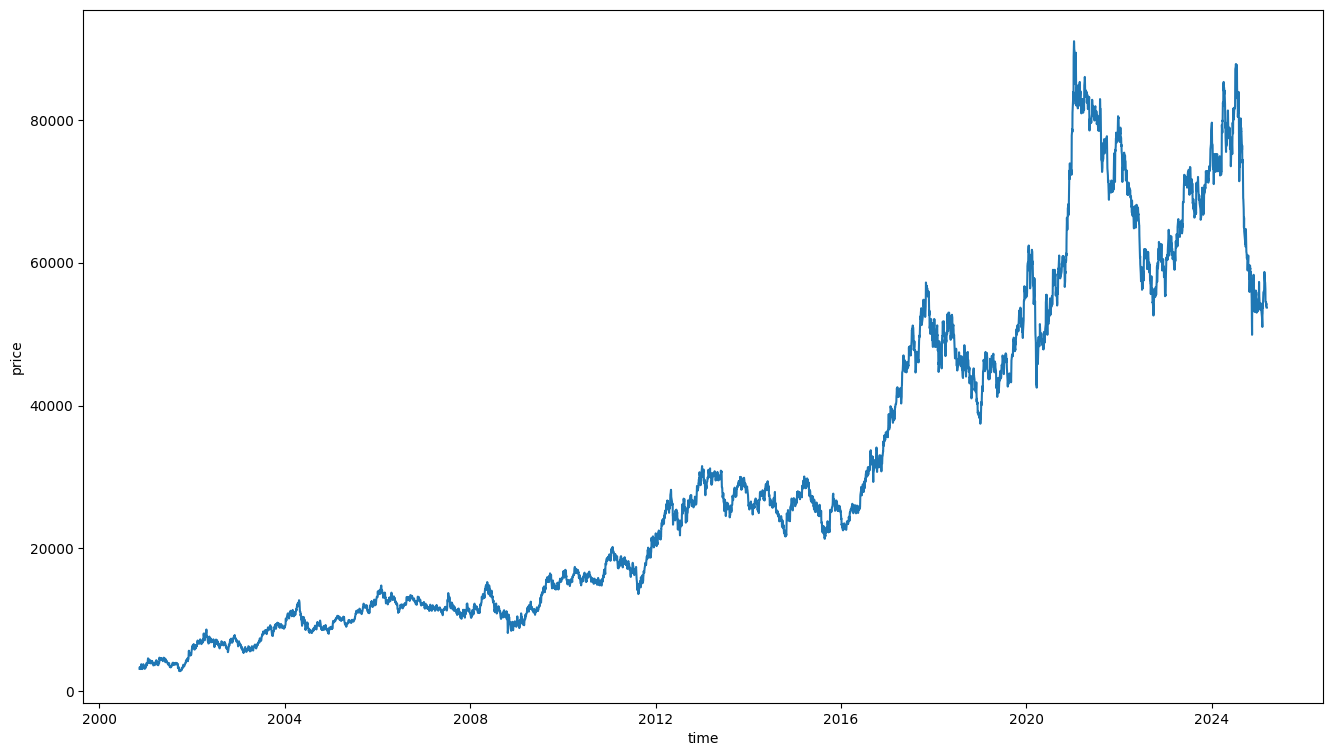

In [23]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

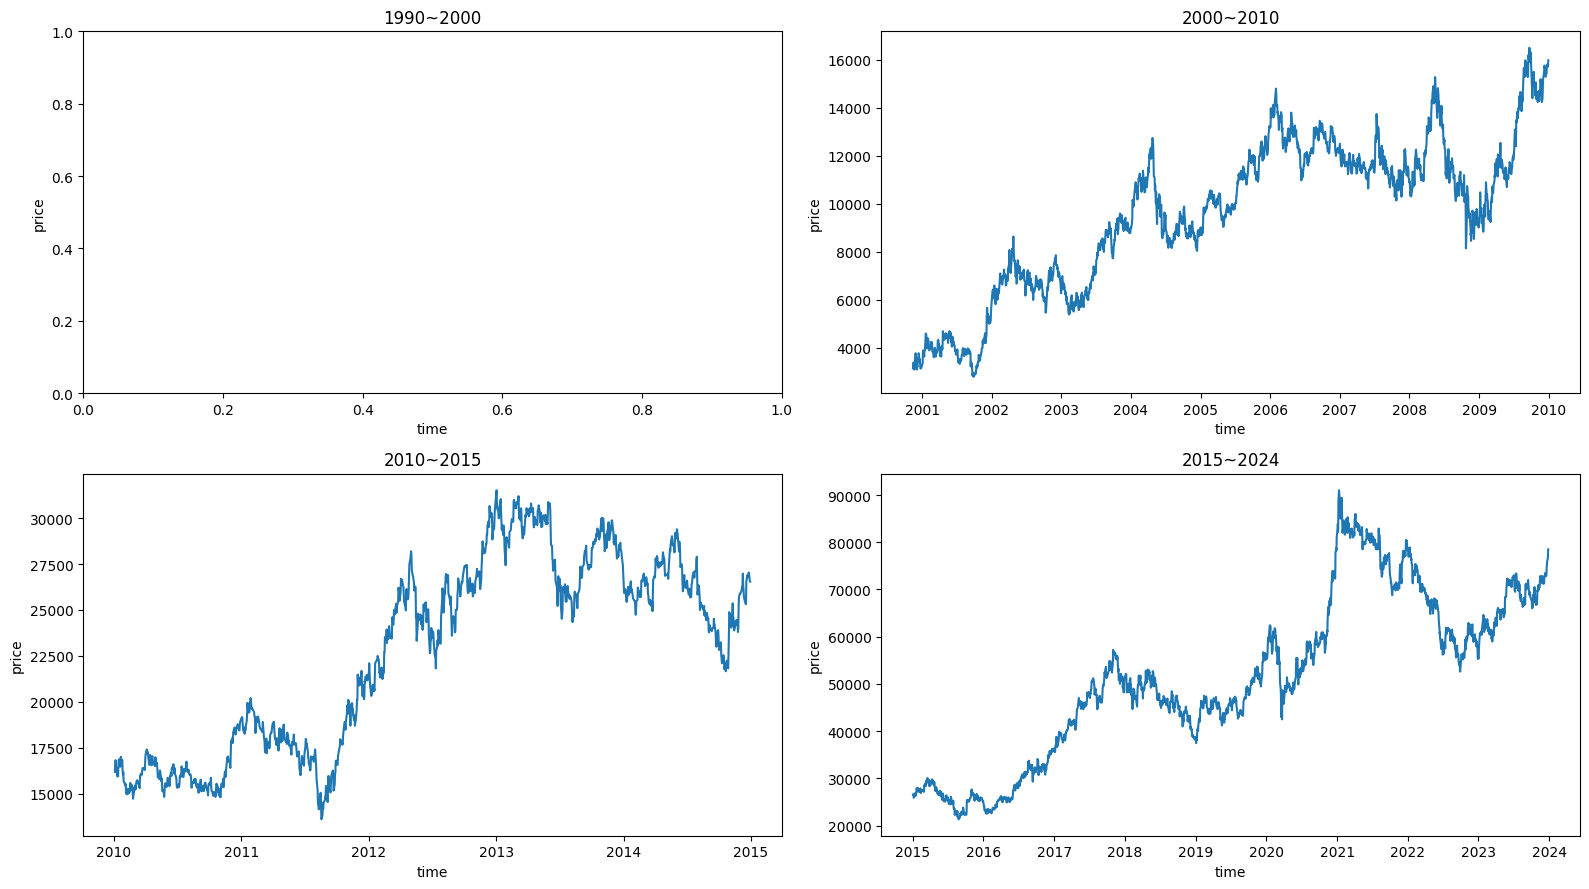

In [24]:
time_steps = [['1990', '2000'],
              ['2000', '2010'],
              ['2010', '2015'],
              ['2015', '2024']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

## 데이터 전처리

주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 **정규화(Normalization)**를 해주도록 하겠습니다.

**표준화 (Standardization)**와 **정규화(Normalization)**에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

- [데이터 전처리에 관하여](https://teddylee777.github.io/scikit-learn/scikit-learn-preprocessing)

In [25]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[0.03565891, 0.03367769, 0.03463687, 0.00396825, 0.01131104],
       [0.03554817, 0.03429752, 0.03586592, 0.00555556, 0.00703334],
       [0.03819491, 0.0357438 , 0.0370838 , 0.00668934, 0.01234095],
       ...,
       [0.59911406, 0.56301653, 0.60335196, 0.58390023, 0.13573934],
       [0.59246955, 0.55991736, 0.59664804, 0.57709751, 0.15807326],
       [0.59246955, 0.5661157 , 0.59776536, 0.57709751, 0.1415223 ]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

**시간 순으로 정렬**되어 있으며, datetime index는 제외했습니다.

*6,000개의 row, 5개 column*으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [26]:
df = pd.DataFrame(scaled, columns=scale_cols)

## train / test 분할

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', axis=1), df['Close'], test_size=0.2, random_state=0, shuffle=False)

In [29]:
x_train.shape, y_train.shape

((4800, 4), (4800,))

In [30]:
x_test.shape, y_test.shape

((1200, 4), (1200,))

In [31]:
x_train

,Open,High,Low,Volume
0,0.035659,0.033678,0.034637,0.011311
1,0.035548,0.034298,0.035866,0.007033
2,0.038195,0.035744,0.037084,0.012341
3,0.037652,0.035331,0.036313,0.008288
4,0.035216,0.033368,0.035196,0.008023
...,...,...,...,...
4795,0.542082,0.508781,0.543575,0.197540
4796,0.538760,0.505165,0.539665,0.159810
4797,0.540421,0.508264,0.539665,0.157312
4798,0.546512,0.509814,0.542458,0.258562


## TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성

In [32]:
import tensorflow as tf

In [33]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.

In [34]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [35]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [36]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


## 모델

In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [38]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [39]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.weights.h5')
checkpoint = ModelCheckpoint(filename,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

In [40]:
history = model.fit(train_data,
                    validation_data=(test_data),
                    epochs=50,
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
    150/Unknown 8s 9ms/step - loss: 5.4000e-04 - mse: 0.0011
Epoch 1: val_loss improved from inf to 0.00207, saving model to tmp/ckeckpointer.weights.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 5.3817e-04 - mse: 0.0011 - val_loss: 0.0021 - val_mse: 0.0041
Epoch 2/50
150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6351e-05 - mse: 5.2701e-05
Epoch 2: val_loss improved from 0.00207 to 0.00158, saving model to tmp/ckeckpointer.weights.h5
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 2.6580e-05 - mse: 5.3159e-05 - val_loss: 0.0016 - val_mse: 0.0032
Epoch 3/50
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3864e-05 - mse: 4.7727e-05
Epoch 3: val_loss did not improve from 0.00158
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - loss: 2.4535e-05 - mse: 4.9070e-05 - val_loss: 0.0024 - val_mse: 0.0049
Epoch 4/50
143/150 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1763e-05 - mse: 4.3525e-05
Epoch 4: val_loss did not improve from 0.00158
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 8

저장한 ModelCheckpoint 를 로드합니다.

In [41]:
model.load_weights(filename)

`test_data`를 활용하여 예측을 진행합니다.

In [42]:
pred = model.predict(test_data)

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [43]:
pred.shape

(1180, 1)

In [44]:
print(pred)

[[0.5251479 ]
 [0.5290112 ]
 [0.5307124 ]
 ...
 [0.59959304]
 [0.5929706 ]
 [0.5884394 ]]


## 예측 데이터 시각화

아래 시각화 코드중 y_test 데이터에 **[20:]**으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 *앞의 20일은 예측하지 않습니다.*

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

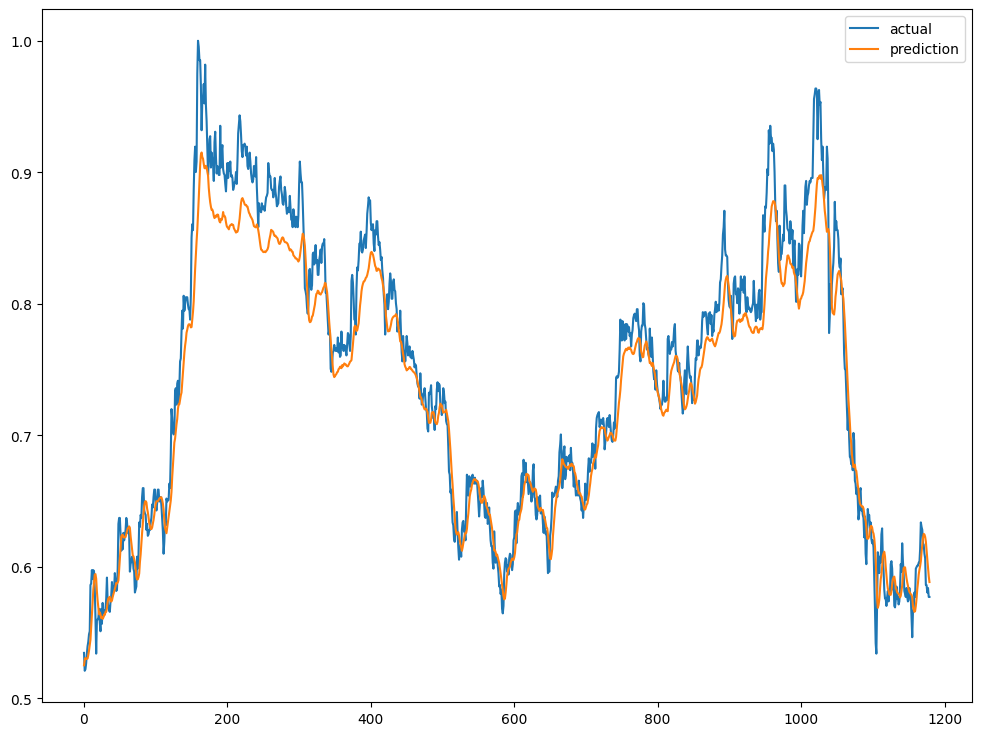

In [45]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()